In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, pickle, time, sys
import mne
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
from utils import *
# %matplotlib qt
import neurokit2 as nk
from scipy.stats import entropy
# from scipy import stats
from pyentrp import entropy as ent
from scipy.signal import welch, find_peaks, savgol_filter
from pyentrp import entropy as ent
from scipy.stats import moment
from scipy.signal import butter, lfilter
# from PyEMD import EMD
import pywt
import nolds
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = (10,8)

In [3]:
def read_emg_csv(parent_folder, folder, subfolder):
    path = os.path.join(parent_folder, folder, "Myo", subfolder, "EMG.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        # markers = df[' Marker'].unique()
        # # print(markers)
        # # count = df[' Marker'].value_counts()
        # # print(count)
        data = {}
        myo_elctrodes = [' Electrode 1', ' Electrode 2', ' Electrode 3',' Electrode 4', ' Electrode 5', ' Electrode 6', ' Electrode 7', ' Electrode 8']
        for i , (dir, s,e) in enumerate(zip(['Y' , 'Z', 'X'],[1000, 2000, 3000], [1001, 2001, 3001])):
            start_row_indices = df[df[' Marker'] == s].index
            end_row_indices = df[df[' Marker'] == e].index
            data[f'TskDir_{dir}'] = []
            for start, end in zip(start_row_indices, end_row_indices):
                data[f'TskDir_{dir}'].append(df.iloc[start + 1: end][myo_elctrodes].values)
        # print(f"Successfully read EMG.csv in {os.path.join(parent_folder, folder, 'Myo', subfolder)}")
        return data
    else:
        # print(f"EMG.csv not found in {os.path.join(parent_folder, folder, 'Myo', subfolder)}")
        return None
    
parent_folder_path = 'D:/VIP_MRTK3/EMG_Data/ismar2023/Experimental_Database'
subfolder_names = ["ControllerAndPen", "TwoControllers", "TwoHand"]
EMG_Dataset = {}
for folder in os.listdir(parent_folder_path):
    if os.path.isdir(os.path.join(parent_folder_path, folder)):
        EMG_Dataset[f'{folder}'] = {}
        for subfolder in subfolder_names:
            EMG_Dataset[f'{folder}'][f'{subfolder}'] = read_emg_csv(parent_folder_path, folder, subfolder)
            
print(EMG_Dataset.keys())       
print(EMG_Dataset['P11_Data'].keys())
print(EMG_Dataset['P11_Data']['TwoControllers'].keys())

dict_keys(['P01_Data', 'P02_Data', 'P03_Data', 'P04_Data', 'P05_Data', 'P06_Data', 'P07_Data', 'P08_Data', 'P09_Data', 'P10_Data', 'P11_Data', 'P12_Data', 'P13_Data', 'P14_Data', 'P15_Data', 'P16_Data', 'P17_Data', 'P18_Data', 'P19_Data', 'P20_Data', 'P21_Data', 'P22_Data', 'P23_Data', 'P24_Data', 'P25_Data'])
dict_keys(['ControllerAndPen', 'TwoControllers', 'TwoHand'])
dict_keys(['TskDir_Y', 'TskDir_Z', 'TskDir_X'])


In [5]:
#================================================================================
#                            [Butter Bandpass]
#================================================================================
def butter_bandpass(lowcut, highcut, fs, order=5):
   nyq = 0.5 * fs
   low = lowcut / nyq
   high = highcut / nyq
   b, a = butter(order, [low, high], btype='band')
   return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
   b, a = butter_bandpass(lowcut, highcut, fs, order=order)
   y = lfilter(b, a, data)
   return y

#================================================================================
#                            [Willison Amplitude]
#================================================================================
def cal_willison_amplitude(emg_data, threshold=0.1):
    'emg shape: [pnts, channel]'
    diff_data = np.diff(emg_data, axis=0)
    wamp = np.sum(np.abs(diff_data) > threshold, axis=0)
    return wamp

#================================================================================
#                            [Simple Square Integral]
#================================================================================
def cal_simple_square_integral(emg_data):
    'emg shape: [pnts, channel]'
    ssi = np.sum(emg_data**2, axis=0)
    return ssi
#================================================================================
#                            [Integrated EMG]
#================================================================================
def cal_integrated_emg(emg_data):
    'emg shape: [pnts, channel]'
    iemg = np.sum(np.abs(emg_data), axis=0)
    return iemg

#================================================================================
#                            [Mean Absolute Value]
#================================================================================

def cal_mav(emg_data):
    'emg shape: [pnts, channel]'
    mav = np.mean(np.abs(emg_data), axis=0)
    return mav

#================================================================================
#                            [Root Mean Square]
#================================================================================
def cal_root_mean_square(emg_data):
    'emg shape: [pnts, channel]'
    rms = np.sqrt(np.mean(emg_data**2, axis=0))
    return rms

#================================================================================
#                            [Median Frequency]
#================================================================================
def cal_median_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mdf = []
    for elec_idx in range(emg_data.shape[1]):
        electrode_data = emg_data[:, elec_idx]
        freqs, Pxx = welch(electrode_data, fs, nperseg=nperseg)
        cumsum = np.cumsum(Pxx)
        median_freq = freqs[np.where(cumsum >= cumsum[-1] / 2)[0][0]]
        mdf.append(median_freq)
    mdf = np.array(mdf)
    return mdf

#================================================================================
#                            [Mean Frequency]
#================================================================================
def cal_mean_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mnf = []
    for elec_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, elec_idx], fs, nperseg=nperseg)
        mnf.append(np.sum(f * Pxx) / np.sum(Pxx))
    mnf = np.array(mnf)
    return mnf

#================================================================================
#                            [Peak Frequency]
#================================================================================
def cal_peak_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    pkf = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        pkf.append(f[np.argmax(Pxx)])
    pkf = np.array(pkf)
    return pkf

#================================================================================
#                            [Mean Power]
#================================================================================
def cal_mean_power(emg_data, fs=200, nperseg =200):
    mnp = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        mnp.append(np.mean(Pxx))
    
    mnp = np.array(mnp)
    return mnp

#================================================================================
#                            [Total Power]
#================================================================================
def cal_total_power(emg_data, fs=200, nperseg=200):
    ttp = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        ttp.append(np.sum(Pxx))
    ttp = np.array(ttp)

    return ttp

#================================================================================
#                            [Waveform Lenght]
#================================================================================
def cal_waveform_length(emg_data):
    'emg shape: [pnts, channel]'
    wl = np.sum(np.abs(np.diff(emg_data, axis=0)), axis=0)
    return wl

#================================================================================
#                            [Sample Entropy]
#================================================================================
def cal_sample_entropy(emg_data, m=2, r=0.2):
    'emg shape: [pnts, channel]'
    sentropy = []
    for elec_idx in range(emg_data.shape[1]):
        se = ent.sample_entropy(emg_data[:, elec_idx], m, r)
        sentropy.append(se[-1])  # Use the last value (m = 2)
    return np.array(sentropy)

#================================================================================
#                            [Slop Sign Change]
#================================================================================
def cal_slope_sign_changes(emg_data):
    'emg shape: [pnts, channel]'
    diff_data = np.diff(emg_data, axis=0)
    ssc = np.sum((diff_data[:-1, :] * diff_data[1:, :]) < 0, axis=0)
    return ssc

#================================================================================
#                            [Zero Crossing Rate]
#================================================================================
def cal_zero_crossing_rate(emg_data):
    'emg shape: [pnts, channel]'
    zcr = np.sum((emg_data[:-1, :] * emg_data[1:, :]) < 0, axis=0)
    return zcr

#================================================================================
#                            [Hjorth]
#================================================================================
def cal_hjorth_parameters(emg_data):
    'emg shape: [pnts, channel]'
    first_derivative = np.diff(emg_data, axis=0)
    second_derivative = np.diff(first_derivative, axis=0)

    activity = np.mean(emg_data**2, axis=0)
    mobility = np.mean(first_derivative**2, axis=0) / activity
    complexity = (np.mean(second_derivative**2, axis=0) / np.mean(first_derivative**2, axis=0)) / mobility

    return activity, mobility, complexity

#================================================================================
#                            [Spectral Moments]
#================================================================================
def cal_spectral_moments(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mean_frequency, variance_frequency  = [], []
    
    for elec_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, elec_idx], fs=fs, nperseg=nperseg)
        mean_freq = np.sum(f * Pxx) / np.sum(Pxx)
        mean_frequency.append(mean_freq)
        variance_frequency.append(moment(Pxx, moment=2))
        
    mean_frequency = np.array(mean_frequency)
    variance_frequency = np.array(variance_frequency)

    return mean_frequency, variance_frequency

#================================================================================
#                            [Wavelet Transform]
#================================================================================

def cal_wavelet_transform(emg_data, wavelet='db4'):
    'emg shape: [pnts, channel]'

    wavelet_coeffs_list = pywt.wavedec(emg_data, wavelet, axis=0)

    return wavelet_coeffs_list

#================================================================================
#                            [Deterended Fluctuations Analysis]
#================================================================================

def cal_detrended_fluctuation_analysis(emg_data):
    'emg shape: [pnts, channel]'
    dfa = []
    for elec_idx in range(emg_data.shape[1]):
        dfa.append(nolds.dfa(emg_data[:, elec_idx]))
    return np.array(dfa)

#================================================================================
#                            [Windowing]
#================================================================================

def window_emg_data(emg_data, fs, window_length, overlap=0):
    'emg shape: [pnts, channel]'
    num_samples, num_electrodes = emg_data.shape
    window_length = int(window_length*fs)
    overlap = int(overlap * fs)
    step_size = window_length - overlap
    num_windows = (num_samples - overlap) // step_size

    windowed_emg_data = np.empty((window_length, num_windows, num_electrodes))

    for win_idx in range(num_windows):
        start_sample = win_idx * step_size
        end_sample = start_sample + window_length
        windowed_emg_data[:, win_idx, :] = emg_data[start_sample:end_sample, :]
    return windowed_emg_data

#================================================================================
#                            [Plot EMG]
#================================================================================

def plot_emg(data_list, fig_size=(12, 8), scale=1.01, ylim=None):
    'data is a list of inputs with shape of [pnts, channel]'
    
    channel= data_list[0].shape[1]
    channel_max = 0.0
    fig, ax = plt.subplots(channel, 1, sharex=True, figsize=fig_size)
    for i in range(channel):
        for j in range(len(data_list)):
            data = data_list[j]
            ax[i].plot(data[:, i], linewidth=0.5)
            if ylim is None:
                channel_max_cur = np.max(np.abs(data[:,i])) * scale
                if channel_max_cur>channel_max:
                    channel_max = channel_max_cur
                ax[i].set_ylim(-channel_max, channel_max)
            else:
                ax[i].set_ylim(ylim[0], ylim[1])
            ax[i].set_ylabel(f'Channel {i+1}')
            if i == channel-1:
                ax[i].set_xlabel('Time')
    plt.tight_layout()
    plt.show()
    

#================================================================================
#                            [EMG Trend]
#================================================================================ 

def regressor(data, fs=200, regressor='linear', plot_trend=False):
    'data shape: [pnts, channel]'
    time = np.arange(0, len(data))
    num_channels = data.shape[1]
    
    regression_models, regression_slopes = [], []
    for i in range(num_channels):
        channel_data = data[:, i].reshape(-1, 1)
        time_reshaped = time.reshape(-1, 1)
        
        if regressor=='linear':
            # linear regressor
            model = LinearRegression()
            model.fit(time_reshaped, channel_data)
            regression_models.append(model)
            regression_slopes.append(model.coef_[0])
            
        elif regressor=='svr':
            # Support vector regressor 
            model = SVR(kernel='rbf', C=1e3, gamma=0.1)
            model.fit(time_reshaped, channel_data.ravel())
            regression_models.append(model)
            
        elif regressor=='rf':
            # RF regressor 
            model = RandomForestRegressor(n_estimators=100, random_state=0)
            model.fit(time_reshaped, channel_data.ravel())
            regression_models.append(model)
        else:
            raise 'TypeError' "current regressors are 'linear' | 'svr' | 'rf'"

    # Visualize the fitted regression curves
    # fitted_curve = np.array([model.predict(time_reshaped).squeeze() for model in regression_models])
    # plot_emg([data, fitted_curve.T])
    if plot_trend:
        if num_channels == 1:
            fig, ax = plt.subplots(figsize=(10, 5))
            axs = [ax]
        else:
            fig, axs = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels))
        
        # fig, axs = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels))
        for i, model in enumerate(regression_models):
            channel_data = data[:, i]
            fitted_curve = model.predict(time_reshaped)

            axs[i].plot(time, channel_data, label='EMG Channel {}'.format(i+1))
            axs[i].plot(time, fitted_curve, label='Fitted Regression Curve', linestyle='--')
            axs[i].set_xlabel('Time (s)')
            axs[i].set_ylabel('Amplitude')
            axs[i].legend()

        plt.tight_layout()
        plt.show() 
    
    return np.array(regression_slopes)[:,0]

In [12]:
records = []
# Iterate over subjects
for subject, subject_data in EMG_Dataset.items():
    # Iterate over objects
    for object_name, object_data in subject_data.items():
        # Iterate over directions
        for direction, direction_data in object_data.items():
            # Iterate over repetitions
            for repetition in range(4):
                
                # read data
                x = EMG_Dataset[subject][object_name][direction][repetition]
                # print(f'input data: {x.shape}')
                
                # preprocessing
                x_f = butter_bandpass_filter(x, fs=200, lowcut=20, highcut=90)
                # x_rect = np.abs(x_f)
                # x_smooth = savgol_filter(x_rect, window_length=10, polyorder=2, axis=0, mode='interp')
                maximum_voluntary_contraction = np.max(x_f, axis=0)
                x_norm = x_f/maximum_voluntary_contraction
                x_p = x_norm         # change what kinf of data you want to use for process[raw | normalized| Rectified]
                
                # Windowing
                win_len = 0.2
                # print(f'max win_len is {x.shape[0]/200}')
                overlap = 0.1
                if win_len is None:
                    x_win = x_p[:, None, :]
                else:
                    x_win = window_emg_data(x_p, fs=200, window_length=win_len, overlap=overlap)
                # print(x_win.shape)
                
                # Feature Extraction
                x_feature = []
                for i in range (x_win.shape[1]):
                    # mav = cal_mav(x_win[:,i,:])
                    # mnf = cal_mean_frequency(x_win[:,i,:], fs=200, nperseg=x_win.shape[0])
                    # mdf = cal_median_frequency(x_win[:,i,:], fs=200, nperseg=x_win.shape[0])
                    rms = cal_root_mean_square(x_win[:,i,:])
                    x_feature.append(rms)
                  
                # regressor line slope inside each repeation
                if x_win.shape[1]>1:
                    # print('windowed features')
                    # x_feature = regressor(np.array(x_feature), plot_trend=False)[None,:]
                    x_feature = np.mean(np.array(x_feature), axis=0, keepdims=True)
                    # x_feature = np.median(np.array(x_feature), axis=0, keepdims=True)
                else:
                    # print('non-windowed features')
                    x_feature = np.array(x_feature)
                    
                # print(x_feature.shape)
                
                record = {
                    'Subject': subject,
                    'Object': object_name,
                    'Direction': direction,
                    'Repetition': repetition+1,
                    'Channel1': x_feature[0,0],
                    'Channel2': x_feature[0,1],
                    'Channel3': x_feature[0,2],
                    'Channel4': x_feature[0,3],
                    'Channel5': x_feature[0,4],
                    'Channel6': x_feature[0,5],
                    'Channel7': x_feature[0,6],
                    'Channel8': x_feature[0,7],
                    'ChannelAvg': np.mean(x_feature)
                }
                records.append(record)

df = pd.DataFrame(records)
df

[[ -1  -3   1   6  29  18  -9  16]
 [ -5  -5  -3  -7 -20  -2   2 -14]
 [  7   8   6  12  37  31   9  -2]
 [ -2  -6  -4  -4 -34 -60 -28  26]
 [ -1   2   3   8  24  24  23  -4]
 [ -3  -2  -3  -8 -15  -9 -19  -3]
 [ -6  -4  -6  -9 -22  -6   1  -5]
 [ -2   1   7   3  10  15   4  14]
 [ -3  -3  -5  -4 -19 -34 -15 -11]
 [ -3   1   0   3   9   8   4  -2]]
[[-11  -5  -1  -3   0  -1 -12  -4]
 [  1   2   1   4  16  45  20  -5]
 [ 11   1  -3  -4   4  12  13  14]
 [ -3  -2   0  -2   0 -10 -15  -5]
 [ -2  -3   0   0  -7  -5   3  -2]
 [-10   6  -1  -5 -12 -26 -26 -14]
 [ -2  -1  -2   0  11  17   2   1]
 [ -6  -5   1   0   0  -3   1  -5]
 [  2  -1  -7  -5 -10  -7 -13  -4]
 [  3  -1   6   0   9  14   3  -1]]
[[ -1  -1  -3   0  -3   4   5  -5]
 [ -1  -2  -4  -2  -3 -13  -5   4]
 [ -2  -3  -4  -1  -4  -7   3  -1]
 [ -3  -7 -10  -2  -3   4   6  -1]
 [  6  16  15   0  -5 -16  -4  -1]
 [  0   2   5   7  11  16   8   5]
 [ -1   0  -2   6  12  23  -2  11]
 [ -3  -7  -7  -7  -6 -14   1 -10]
 [ -3  -7 -10  -7 

,Subject,Object,Direction,Repetition,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,ChannelAvg
0,P01_Data,ControllerAndPen,TskDir_Y,1,0.209054,0.098547,0.181731,0.082836,0.159033,0.176030,0.243165,0.228493,0.172361
1,P01_Data,ControllerAndPen,TskDir_Y,2,0.101298,0.133027,0.121417,0.135557,0.176517,0.192652,0.190799,0.157185,0.151057
2,P01_Data,ControllerAndPen,TskDir_Y,3,0.125930,0.068028,0.113060,0.104402,0.216214,0.108201,0.194241,0.188022,0.139762
3,P01_Data,ControllerAndPen,TskDir_Y,4,0.112875,0.092859,0.154862,0.157816,0.150410,0.219120,0.219668,0.231574,0.167398
4,P01_Data,ControllerAndPen,TskDir_Z,1,0.210780,0.116603,0.132690,0.173351,0.205236,0.153545,0.216562,0.190063,0.174854
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,P25_Data,TwoHand,TskDir_Z,4,0.122443,0.179790,0.184328,0.140846,0.115526,0.168518,0.177996,0.296825,0.173284
896,P25_Data,TwoHand,TskDir_X,1,0.172170,0.233293,0.225469,0.178728,0.178680,0.234398,0.217752,0.187331,0.203478
897,P25_Data,TwoHand,TskDir_X,2,0.132451,0.227729,0.192549,0.137515,0.127772,0.244433,0.217597,0.227970,0.188502
898,P25_Data,TwoHand,TskDir_X,3,0.198903,0.232340,0.216726,0.198115,0.198315,0.184479,0.136672,0.197905,0.195432


In [5]:
df['Object'] = df['Object'].map({'ControllerAndPen':'Pen', 'TwoControllers':'Controller', 'TwoHand':'Hand'})
df['Direction'] = df['Direction'].map({'TskDir_X':'X', 'TskDir_Y':'Y', 'TskDir_Z':'Z'})

In [95]:
# import matplotlib.pyplot as plt

# def plot_features(df, subject_id, object_id, direction):
#     subject_data = df[(df['Subject'] == subject_id) & (df['Object'] == object_id) & (df['Direction'] == direction)]
#     # assuming 'rms', 'mav', 'mnf', 'mdf' columns are averages of all channels
#     # for feature in ['rms', 'mav', 'mnf', 'mdf']:
#     plt.figure(figsize=(10, 4))
#     plt.plot(subject_data['ChannelAvg'])
#     plt.title(f'ChannelAvg for subject {subject_id}, object {object_id}, direction {direction}')
#     plt.xlabel('repetition')
#     plt.ylabel('ChannelAvg')
#     plt.show()

# # call the function
# plot_features(df, subject_id='P19_Data', object_id='Pen', direction='Y')

### Primary Visualization of data


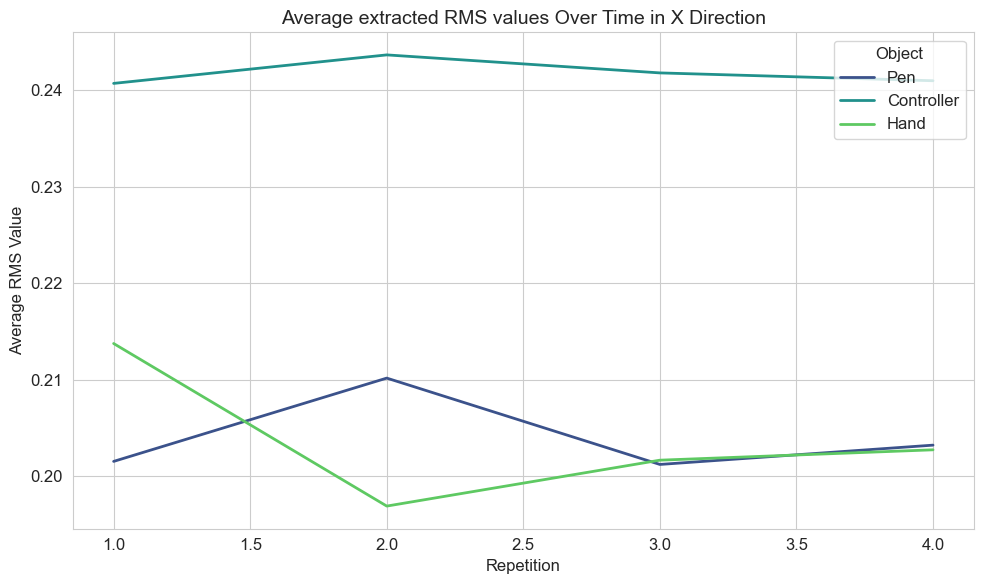

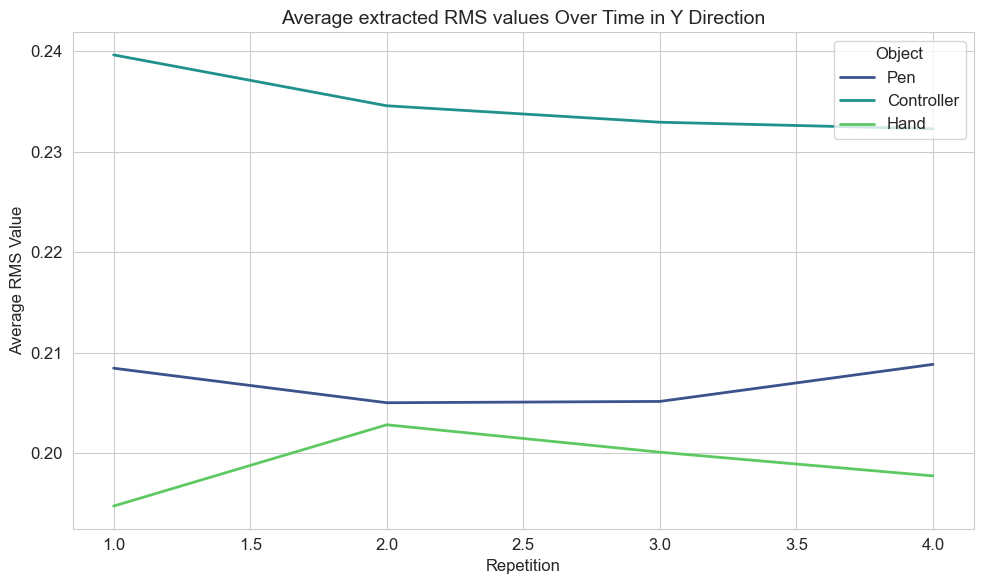

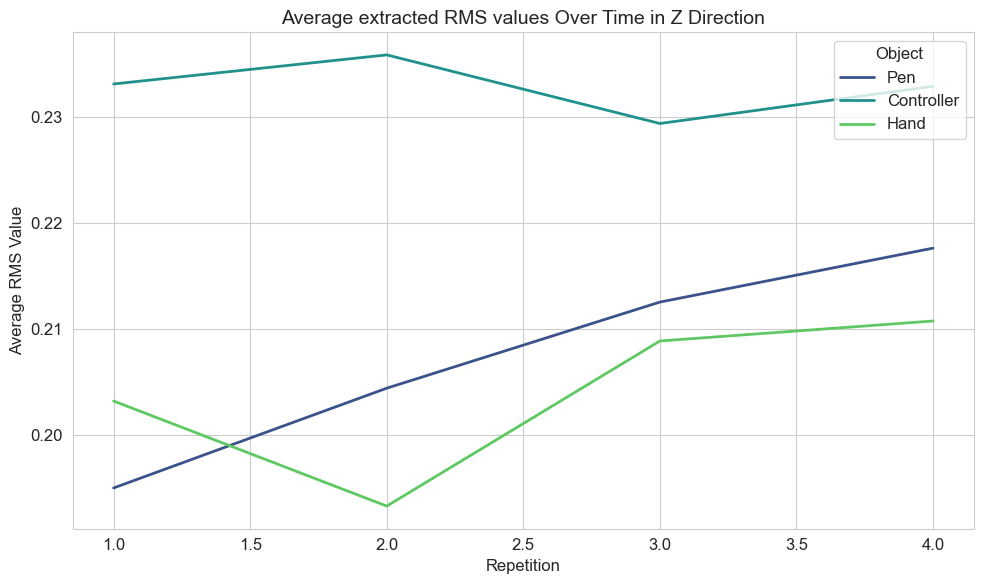

In [6]:
directions = ['X', 'Y', 'Z']
# channels = ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Channel6', 'Channel7', 'Channel8', 'ChannelAvg']
channels = ['ChannelAvg']


plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2})

for direction in directions:
    for channel in channels:
        # print(f'dir: {direction} | ch: {channel}')
        plt.figure(figsize=(10,6))
        # Setting the overall style of the plot
        sns.set_style("whitegrid")
        sns.lineplot(data=df[df['Direction'] == direction], x='Repetition', y=channel, hue='Object', errorbar=None,estimator=np.mean, palette='viridis')
        plt.title(f'Average extracted RMS values Over Time in {direction} Direction',fontsize=14)
        plt.xlabel('Repetition', fontsize=12)
        plt.ylabel(f'Average RMS Value', fontsize=12)
        plt.legend(title='Object', title_fontsize='12', loc='upper right')
        plt.tight_layout()
        plt.show()

### T-test

Explain the results: This is explanaition for the Slope for RMS data

Following table displays the results of pairwise t-tests between the three objects (Pen, Controller, and Hand) for each repetition and direction. The t-tests compare the average RMS slopes (i.e., rates of fatigue) for different objects. Here's an interpretation of the results:

* Direction X: In the first repetition, the slope of RMS values (i.e., the rate of fatigue) is significantly different when comparing the Controller and Hand, with a lower mean slope for the Controller (negative t-statistic). This pattern also holds true for the second, fifth, seventh, and eighth repetitions. However, in the seventh repetition, the slope for the Pen is significantly higher than that of the Controller (positive t-statistic). In the eighth repetition, the slope for the Pen is significantly lower than that of the Hand.

* Direction Y: Here, the Hand shows significantly higher fatigue rates than the Pen in the first, third, fourth, fifth, sixth, and eighth repetitions (negative t-statistics). The Controller also shows significantly higher fatigue rates than the Hand in the third, fourth, sixth, and eighth repetitions. In the fifth repetition, the Pen shows a significantly higher fatigue rate than the Controller.

* Direction Z: In the fifth and ninth repetitions, the Pen shows a significantly higher fatigue rate than the Controller.

These results suggest that the rate of muscular fatigue, as measured by the slope of RMS values, varies significantly depending on the object used and the direction of the task. In general, the Hand seems to exhibit higher rates of fatigue (higher RMS slopes), particularly when compared to the Pen or Controller in certain directions and repetitions.(Strange)

   Direction     Channel  Repetition          Comparison    t_stat     p_val
0          X  ChannelAvg           1   Pen vs Controller -2.236721  0.029986
1          X  ChannelAvg           2   Pen vs Controller -2.684750  0.009934
2          X  ChannelAvg           2  Controller vs Hand  3.172469  0.002636
3          X  ChannelAvg           3   Pen vs Controller -4.390448  0.000062
4          X  ChannelAvg           3  Controller vs Hand  4.280445  0.000089
5          X  ChannelAvg           4   Pen vs Controller -4.129334  0.000144
6          X  ChannelAvg           4  Controller vs Hand  3.750824  0.000475
7          X  ChannelAvg           5   Pen vs Controller -3.848909  0.000350
8          X  ChannelAvg           5  Controller vs Hand  3.113894  0.003110
9          X  ChannelAvg           6   Pen vs Controller -3.324275  0.001704
10         X  ChannelAvg           6  Controller vs Hand  2.947458  0.004934
11         X  ChannelAvg           7   Pen vs Controller -2.427033  0.019026

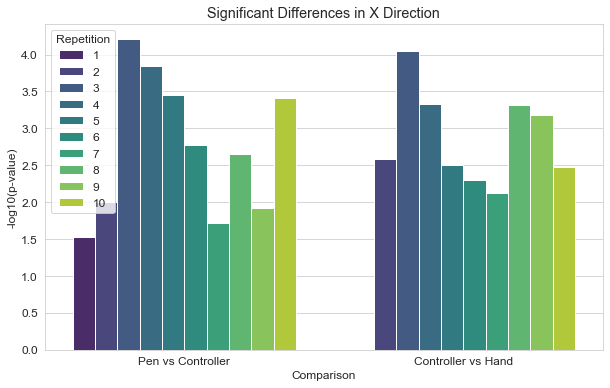

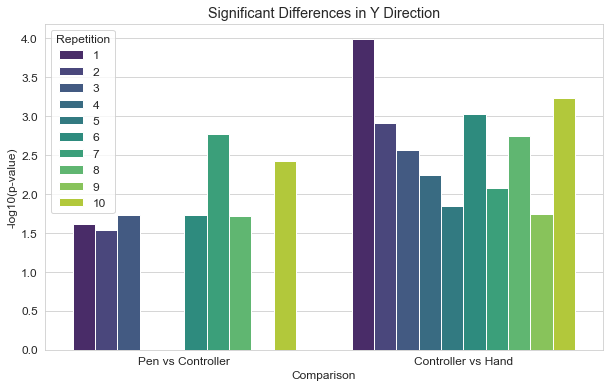

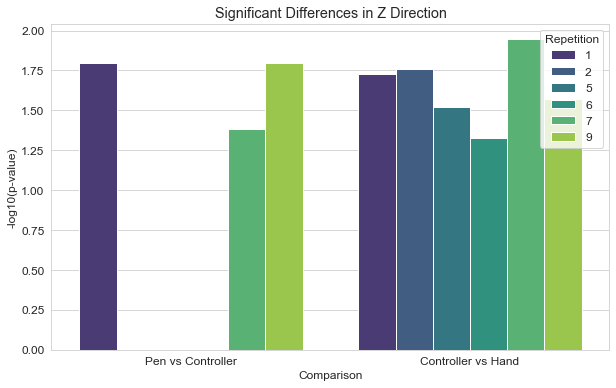

In [107]:
repetitions = df['Repetition'].unique()
results = []

for direction in directions:
    for channel in channels:
        for repetition in repetitions:
            controller_and_pen = df[(df['Object']=='Pen') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            two_controllers = df[(df['Object']=='Controller') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            two_hand = df[(df['Object']=='Hand') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            
            t_stat_1, p_val_1 = ss.ttest_ind(controller_and_pen, two_controllers)
            t_stat_2, p_val_2 = ss.ttest_ind(controller_and_pen, two_hand)
            t_stat_3, p_val_3 = ss.ttest_ind(two_controllers, two_hand)
            
            if p_val_1 < 0.05:
                results.append({
                    'Direction': direction,
                    'Channel': channel,
                    'Repetition': repetition,
                    'Comparison': 'Pen vs Controller',
                    't_stat': t_stat_1,
                    'p_val': p_val_1
                })
            
            if p_val_2 < 0.05:
                results.append({
                    'Direction': direction,
                    'Channel': channel,
                    'Repetition': repetition,
                    'Comparison': 'Pen vs Hand',
                    't_stat': t_stat_2,
                    'p_val': p_val_2
                })
            
            if p_val_3 < 0.05:
                results.append({
                    'Direction': direction,
                    'Channel': channel,
                    'Repetition': repetition,
                    'Comparison': 'Controller vs Hand',
                    't_stat': t_stat_3,
                    'p_val': p_val_3
                })

t_test_df = pd.DataFrame(results)
print(t_test_df)

t_test_df['-log10(p-value)'] = -np.log10(t_test_df['p_val'])

directions = ['X', 'Y', 'Z']

for direction in directions:
    plt.figure(figsize=(10,6))
    sns.barplot(data=t_test_df[t_test_df['Direction'] == direction], x='Comparison', y='-log10(p-value)', hue='Repetition', palette='viridis')
    plt.title(f'Significant Differences in {direction} Direction')
    plt.ylabel('-log10(p-value)')
    plt.show()

### Correlation


In [108]:
# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=['Object', 'Direction'])

# Calculate correlation
corr_df = df_encoded.corr()

# Extract necessary correlations
object_dir_rep_corr = corr_df.loc[['Repetition', 'Object_Pen', 'Object_Controller', 'Object_Hand'],
                                  ['Direction_X', 'Direction_Y', 'Direction_Z']]

print(object_dir_rep_corr)

                    Direction_X   Direction_Y   Direction_Z
Repetition        -1.151580e-17  1.545158e-17 -8.964831e-18
Object_Pen         4.718448e-18  6.411538e-18  2.026157e-18
Object_Controller -8.104628e-18  1.704192e-17  8.965051e-18
Object_Hand       -4.329870e-18  9.492407e-18 -1.720846e-17


In [109]:
import statsmodels.formula.api as smf

# Create a DataFrame with the average fatigue index for each combination of subject, object, direction, and repetition
df_avg = df.groupby(['Subject', 'Object', 'Direction', 'Repetition'])['ChannelAvg'].mean().reset_index()

# Perform a linear regression with repetition, object, and direction as predictors of the fatigue index
model = smf.ols(formula='ChannelAvg ~ C(Object) + C(Direction) + Repetition', data=df_avg)
results = model.fit()

# Print the summary of the regression results
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:             ChannelAvg   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     57.50
Date:                Sun, 11 Jun 2023   Prob (F-statistic):           1.99e-56
Time:                        18:26:20   Log-Likelihood:                 4636.4
No. Observations:                2250   AIC:                            -9261.
Df Residuals:                    2244   BIC:                            -9226.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2285      0.00

In [73]:
# Convert objects to dummy variables
df_dummy = pd.get_dummies(df, columns=['Object'])

# Calculate correlation coefficients
correlations = df_dummy.corr()

# Extract correlations with ChannelAvg
channel_avg_correlations = correlations['ChannelAvg'].loc[['Object_Pen', 'Object_Controller', 'Object_Hand']]

# Print out correlations
print(channel_avg_correlations)


Object_Pen          -0.126129
Object_Controller    0.329455
Object_Hand         -0.203327
Name: ChannelAvg, dtype: float64


In [74]:
from scipy.stats import pearsonr

# Mapping categorical 'Object' data to numeric
object_mapping = {'Pen': 1, 'Controller': 2, 'Hand': 3}
df['ObjectNumerical'] = df['Object'].map(object_mapping)

# Calculate correlation
correlation, p_value = pearsonr(df['ObjectNumerical'], df['ChannelAvg'])

# Checking if the correlation is significant
if p_value < 0.05:
    print(f'Correlation between Object and ChannelAvg is significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')
else:
    print(f'Correlation between Object and ChannelAvg is not significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')

Correlation between Object and ChannelAvg is significant at 95% level
Correlation coefficient is -0.044570170986898645 and p-value is 0.034513171551857715


In [77]:
# Mapping categorical 'Object' data to numeric
Direction_mapping = {'X': 1, 'Y': 2, 'Z': 3}
df['DirectionNumerical'] = df['Direction'].map(Direction_mapping)

# Calculate correlation
correlation, p_value = pearsonr(df['DirectionNumerical'], df['ChannelAvg'])

# Checking if the correlation is significant
if p_value < 0.05:
    print(f'Correlation between Direction and ChannelAvg is significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')
else:
    print(f'Correlation between Direction and ChannelAvg is not significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')

Correlation between Direction and ChannelAvg is not significant at 95% level
Correlation coefficient is -0.04031767660479116 and p-value is 0.055856952113471525


In [78]:
# Mapping categorical 'Object' data to numeric
# Repetition_mapping = {'X': 1, 'Y': 2, 'Z': 3}
# df['RepetitionNumerical'] = df['Repetition'].map(object_mapping)

# Calculate correlation
correlation, p_value = pearsonr(df['Repetition'], df['ChannelAvg'])

# Checking if the correlation is significant
if p_value < 0.05:
    print(f'Correlation between Direction and ChannelAvg is significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')
else:
    print(f'Correlation between Direction and ChannelAvg is not significant at 95% level')
    print(f'Correlation coefficient is {correlation} and p-value is {p_value}')

Correlation between Direction and ChannelAvg is not significant at 95% level
Correlation coefficient is 0.009472614369125876 and p-value is 0.6533696642489055


### Multi-Factor ANOVA Test

In [ ]:
anova_model = ols('ChannelAvg ~ C(Object) + C(Direction)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
posthoc = pairwise_tukeyhsd(df['ChannelAvg'], df['Object'], alpha=0.05)
print(posthoc)
posthoc = pairwise_tukeyhsd(df['ChannelAvg'], df['Direction'], alpha=0.05)
print(posthoc)

In [ ]:
model = sm.OLS(df['ChannelAvg'], sm.add_constant(df['Repetition'])).fit()
print(model.summary())

In [ ]:
# Regression model with all channels as predictors
predictors = ['Channel'+str(i) for i in range(1, 9)]
model = sm.OLS(df['ChannelAvg'], sm.add_constant(df[predictors])).fit()
print(model.summary())


In [ ]:
sns.boxplot(x='Object', y='ChannelAvg', data=df)
plt.show()

In [ ]:
contingency_table = pd.crosstab(df['Object'], df['Direction'])
chi2, p, dof, expected = ss.chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("p-value:", p)

In [ ]:
# List of subjects
subjects = df['Subject'].unique()

# List to store ChannelAvg values for each subject
data = [df[df['Subject'] == subject]['ChannelAvg'].values for subject in subjects]

# Kruskal-Wallis H-test
H, pval = ss.kruskal(*data)
print('Kruskal-Wallis H-statistic:', H)
print('p-value:', pval)

In [ ]:
repetitions = df['Repetition'].unique()

for direction in directions:
    for channel in channels:
        print(f'\nT-tests for {channel} RMS in {direction} direction:')
        for repetition in repetitions:
            controller_and_pen = df[(df['Object']=='ControllerAndPen') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            two_controllers = df[(df['Object']=='TwoControllers') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            two_hand = df[(df['Object']=='TwoHand') & (df['Direction']==direction) & (df['Repetition']==repetition)][channel]
            
            t_stat_1, p_val_1 = ss.ttest_ind(controller_and_pen, two_controllers)
            t_stat_2, p_val_2 = ss.ttest_ind(controller_and_pen, two_hand)
            t_stat_3, p_val_3 = ss.ttest_ind(two_controllers, two_hand)

            print(f'Repetition {repetition} - ControllerAndPen vs TwoControllers: t={t_stat_1}, p={p_val_1}')
            print(f'Repetition {repetition} - ControllerAndPen vs TwoHand: t={t_stat_2}, p={p_val_2}')
            print(f'Repetition {repetition} - TwoControllers vs TwoHand: t={t_stat_3}, p={p_val_3}')

In [ ]:
# Considering the RMS value of the first channel for simplicity. You can loop over channels.
df['RMS'] = df['ChannelAvg']

# Two-Way ANOVA considering interaction
model = ols('RMS ~ C(Object) + C(Repetition) + C(Object):C(Repetition)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [ ]:
sns.lineplot(data=df, x='Repetition', y='RMS_Slope', hue='Object')
plt.title('RMS Slope across Repetitions')
plt.xlabel('Repetition')
plt.ylabel('RMS Slope')
plt.show()

In [ ]:
df['Object'] = df['Object'].astype('category')
df['Direction'] = df['Direction'].astype('category')

In [ ]:
# ANOVA Test to see if there is a significant difference between groups (Object, Direction)
anova_object = ols('ChannelAvg ~ C(Object)', data=df).fit()
anova_table_object = sm.stats.anova_lm(anova_object, typ=2)
print(anova_table_object)

anova_direction = ols('ChannelAvg ~ C(Direction)', data=df).fit()
anova_table_direction = sm.stats.anova_lm(anova_direction, typ=2)
print(anova_table_direction)

# # Correlation Matrix for numerical columns | Show the correlation heatmap
# correlation_matrix = df.corr()
# print(correlation_matrix)
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()

# # Pairwise plots
# sns.pairplot(df, vars=["Repetition", "ChannelAvg"], hue="Object", height=5)
# sns.pairplot(df, vars=["Repetition", "ChannelAvg"], hue="Direction", height=5)
# plt.show()